<a href="https://colab.research.google.com/github/githma2000/liver-tumor-segmentation/blob/main/liver-tumor%2010.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [71]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [72]:
import os

DATASET_PATH = '/content/drive/MyDrive/Preprocessed_3Dircadb'


In [73]:
import os
import random
import shutil

base_dir = '/content/drive/MyDrive/Preprocessed_3Dircadb'
all_patients = sorted([f for f in os.listdir(base_dir) if f.startswith('3Dircadb')])

# Shuffle and split
random.seed(42)
random.shuffle(all_patients)

train_split = int(0.7 * len(all_patients))
val_split = int(0.85 * len(all_patients))

train_patients = all_patients[:train_split]
val_patients = all_patients[train_split:val_split]
test_patients = all_patients[val_split:]

print("Train:", train_patients)
print("Val:", val_patients)
print("Test:", test_patients)


Train: ['3Dircadb1.9', '3Dircadb1.14', '3Dircadb1.4', '3Dircadb1.13', '3Dircadb1.18', '3Dircadb1.3', '3Dircadb1.5', '3Dircadb1.8', '3Dircadb1.15', '3Dircadb1.20', '3Dircadb1.7', '3Dircadb1.19', '3Dircadb1.10', '3Dircadb1.2']
Val: ['3Dircadb1.11', '3Dircadb1.6', '3Dircadb1.16']
Test: ['3Dircadb1.17', '3Dircadb1.1', '3Dircadb1.12']


In [74]:
from tensorflow.keras.utils import Sequence
import numpy as np
import os
import random
import albumentations as A

class IRCADNPYDataset(Sequence):
    def __init__(self, patient_list, base_path, batch_size=8, input_size=(256, 256),
                 shuffle=True, balance_data=True, seed=42):
        self.patient_list = patient_list
        self.base_path = base_path
        self.batch_size = batch_size
        self.input_size = input_size
        self.shuffle = shuffle
        self.balance_data = balance_data
        self.seed = seed

        # 🔒 Set seeds for reproducibility
        random.seed(self.seed)
        np.random.seed(self.seed)

        # 🎲 Albumentations augmentations
        self.augment = A.Compose([
            A.Resize(height=self.input_size[0], width=self.input_size[1]),

            A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=0.3),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomRotate90(p=0.5),
            A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5),
            A.ElasticTransform(alpha=1, sigma=50, alpha_affine=10, p=0.2),
            A.RandomBrightnessContrast(p=0.2),
            A.GaussianBlur(blur_limit=(3, 5), p=0.1),
        ], additional_targets={'mask': 'mask'})

        self.data = self._load_all_files()
        self.on_epoch_end()

    def _load_all_files(self):
        tumor_data = []
        non_tumor_data = []

        for patient in self.patient_list:
            img_dir = os.path.join(self.base_path, patient, 'PATIENT_2_5D')
            mask_dir = os.path.join(self.base_path, patient, 'LABEL_2_5D')

            img_files = sorted(os.listdir(img_dir))
            mask_files = sorted(os.listdir(mask_dir))

            for img_file, mask_file in zip(img_files, mask_files):
                img_path = os.path.join(img_dir, img_file)
                mask_path = os.path.join(mask_dir, mask_file)

                if os.path.isfile(img_path) and os.path.isfile(mask_path):
                    mask = np.load(mask_path).astype(np.float32)

                    if mask.ndim == 2:
                        mask = np.expand_dims(mask, axis=-1)
                    elif mask.ndim == 3 and mask.shape[2] > 1:
                        mask = mask[..., 0:1]

                    min_val = np.min(mask)
                    max_val = np.max(mask)
                    threshold = min_val + (max_val - min_val) * 0.1
                    binary_mask = (mask > threshold).astype(np.float32)

                    if np.any(binary_mask > 0):
                        tumor_data.append((img_path, mask_path))
                    else:
                        non_tumor_data.append((img_path, mask_path))

        # Balance tumor vs. non-tumor data
        if self.balance_data and len(non_tumor_data) > 0:
            sampled_non_tumor = random.sample(non_tumor_data, min(len(tumor_data), len(non_tumor_data)))
            combined_data = tumor_data + sampled_non_tumor
        else:
            combined_data = tumor_data + non_tumor_data

        return combined_data

    def __len__(self):
        return max(1, len(self.data) // self.batch_size)

    def __getitem__(self, idx):
        batch_pairs = self.data[idx * self.batch_size:(idx + 1) * self.batch_size]
        images, masks = [], []

        for img_path, mask_path in batch_pairs:
            img = np.load(img_path).astype(np.float32)
            mask = np.load(mask_path).astype(np.float32)

            if mask.ndim == 2:
                mask = np.expand_dims(mask, axis=-1)
            elif mask.ndim == 3 and mask.shape[2] > 1:
                mask = mask[..., 0:1]

            # Z-score normalization
            img = (img - np.mean(img)) / (np.std(img) + 1e-5)

            # Binarize mask
            min_val = np.min(mask)
            max_val = np.max(mask)
            threshold = min_val + (max_val - min_val) * 0.1
            mask = (mask > threshold).astype(np.float32)

            # Augmentation
            augmented = self.augment(image=img, mask=mask)
            img_aug = augmented['image']
            mask_aug = augmented['mask']

            # Ensure shape is (H, W, C)
            if img_aug.ndim == 2:
                img_aug = np.expand_dims(img_aug, axis=-1)
            if mask_aug.ndim == 2:
                mask_aug = np.expand_dims(mask_aug, axis=-1)

            images.append(img_aug)
            masks.append(mask_aug)

        return np.array(images), np.array(masks)

    def on_epoch_end(self):
        if self.shuffle:
            random.seed(self.seed)
            random.shuffle(self.data)


In [75]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, UpSampling2D, Input, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50

def ASPP(x, filters):
    """Atrous Spatial Pyramid Pooling with Keras-compatible operations"""
    shape = x.shape

    y1 = Conv2D(filters, 1, padding="same", use_bias=False)(x)
    y1 = BatchNormalization()(y1)
    y1 = Activation("relu")(y1)

    y2 = Conv2D(filters, 3, padding="same", dilation_rate=6, use_bias=False)(x)
    y2 = BatchNormalization()(y2)
    y2 = Activation("relu")(y2)

    y3 = Conv2D(filters, 3, padding="same", dilation_rate=12, use_bias=False)(x)
    y3 = BatchNormalization()(y3)
    y3 = Activation("relu")(y3)

    y4 = Conv2D(filters, 3, padding="same", dilation_rate=18, use_bias=False)(x)
    y4 = BatchNormalization()(y4)
    y4 = Activation("relu")(y4)

    # Use GlobalAveragePooling2D and reshape for broadcast
    y5 = tf.keras.layers.GlobalAveragePooling2D()(x)
    y5 = tf.keras.layers.Reshape((1, 1, shape[-1]))(y5)
    y5 = Conv2D(filters, 1, padding="same", use_bias=False)(y5)
    y5 = BatchNormalization()(y5)
    y5 = Activation("relu")(y5)
    y5 = UpSampling2D(size=(shape[1], shape[2]), interpolation="bilinear")(y5)

    y = concatenate([y1, y2, y3, y4, y5])
    y = Conv2D(filters, 1, padding="same", use_bias=False)(y)
    y = BatchNormalization()(y)
    y = Activation("relu")(y)

    return y


def DeeplabV3Plus(input_shape=(256, 256, 3), num_classes=1):
    """Custom DeepLabV3+ model with ResNet50 backbone"""
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    # Use features from different levels of the encoder
    image_features = base_model.get_layer("conv4_block6_2_relu").output
    x = ASPP(image_features, 256)

    x = UpSampling2D(size=(4, 4), interpolation="bilinear")(x)

    low_level_feat = base_model.get_layer("conv2_block3_2_relu").output
    low_level_feat = Conv2D(48, 1, padding="same", use_bias=False)(low_level_feat)
    low_level_feat = BatchNormalization()(low_level_feat)
    low_level_feat = Activation("relu")(low_level_feat)

    x = concatenate([x, low_level_feat])
    x = Conv2D(256, 3, padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(256, 3, padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = UpSampling2D(size=(4, 4), interpolation="bilinear")(x)
    x = Conv2D(num_classes, 1, padding="same", activation="sigmoid")(x)

    model = Model(inputs=base_model.input, outputs=x)
    return model



In [76]:
import tensorflow as tf

# 1. Define loss function
def dice_loss(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true * y_pred)
    return 1 - (2. * intersection + 1) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + 1)

# 2. Define metric function
def iou_metric(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return (intersection + 1) / (union + 1)

# 3. Define and compile model
model = DeeplabV3Plus(input_shape=(256, 256, 3), num_classes=1)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=dice_loss,
    metrics=[iou_metric]
)

In [54]:
!pip install -U tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 112.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 125.1 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.18.0
    Uninstalling tensorboard-2.18.0:
      Successfully uninstalled tensorboard-2.18.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.18.0
    Uninstalling tensorflow-2.18.0:
      Successfully uninstalled tensorflow-2.18.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-text 2.18.1 requires tensorflow<2.19,>=2.18.0, but you have tensorfl

In [77]:

train_dataset = IRCADNPYDataset(
    train_patients,
    base_dir,
    batch_size=8,
    shuffle=True,
    balance_data=True
)

val_dataset = IRCADNPYDataset(
    val_patients,
    base_dir,
    batch_size=8,
    shuffle=False,
    balance_data=False
)

test_dataset = IRCADNPYDataset(
    test_patients,
    base_dir,
    batch_size=8,
    shuffle=False,
    balance_data=False
)


<ipython-input-74-dc979a059531>:31: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=1, sigma=50, alpha_affine=10, p=0.2),


In [78]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import tensorflow as tf
from tensorflow.keras.optimizers import Adam


early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True,
    mode='min',
    verbose=1
)


checkpoint = tf.keras.callbacks.ModelCheckpoint(
    '/content/drive/MyDrive/best_deeplab_model.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)


lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    mode='min',
    min_lr=1e-6
)


history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    batch_size=16,
    callbacks=[early_stop, checkpoint, lr_schedule]
)


Epoch 1/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - iou_metric: 0.2147 - loss: 0.6541
Epoch 1: val_loss improved from inf to 0.68205, saving model to /content/drive/MyDrive/best_deeplab_model.keras
233/233 ━━━━━━━━━━━━━━━━━━━━ 133s 319ms/step - iou_metric: 0.2150 - loss: 0.6537 - val_iou_metric: 0.1962 - val_loss: 0.6821 - learning_rate: 1.0000e-05
Epoch 2/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - iou_metric: 0.4178 - loss: 0.4171
Epoch 2: val_loss improved from 0.68205 to 0.53123, saving model to /content/drive/MyDrive/best_deeplab_model.keras
233/233 ━━━━━━━━━━━━━━━━━━━━ 113s 302ms/step - iou_metric: 0.4179 - loss: 0.4170 - val_iou_metric: 0.3220 - val_loss: 0.5312 - learning_rate: 1.0000e-05
Epoch 3/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - iou_metric: 0.4913 - loss: 0.3465
Epoch 3: val_loss improved from 0.53123 to 0.49409, saving model to /content/drive/MyDrive/best_deeplab_model.keras
233/233 ━━━━━━━━━━━━━━━━━━━━ 74s 315ms/step - iou_metric: 0.4913 - loss: 0.3465 

In [79]:
import numpy as np
import cv2
from scipy.ndimage import binary_fill_holes, label
from skimage.morphology import remove_small_objects, remove_small_holes, binary_closing

def postprocess_mask(mask, threshold=0.5, min_size=100):
    """
    Post-process a single predicted mask:
    - Threshold
    - Fill holes
    - Remove small objects
    - Morphological closing
    """
    # Binarize
    binary = (mask > threshold).astype(np.uint8)

    # Fill small holes
    binary = binary_fill_holes(binary).astype(np.uint8)

    # Remove small objects
    binary = remove_small_objects(binary.astype(bool), min_size=min_size).astype(np.uint8)

    # Optional: Morphological closing to smooth edges
    binary = binary_closing(binary, selem=np.ones((3, 3))).astype(np.uint8)

    return binary


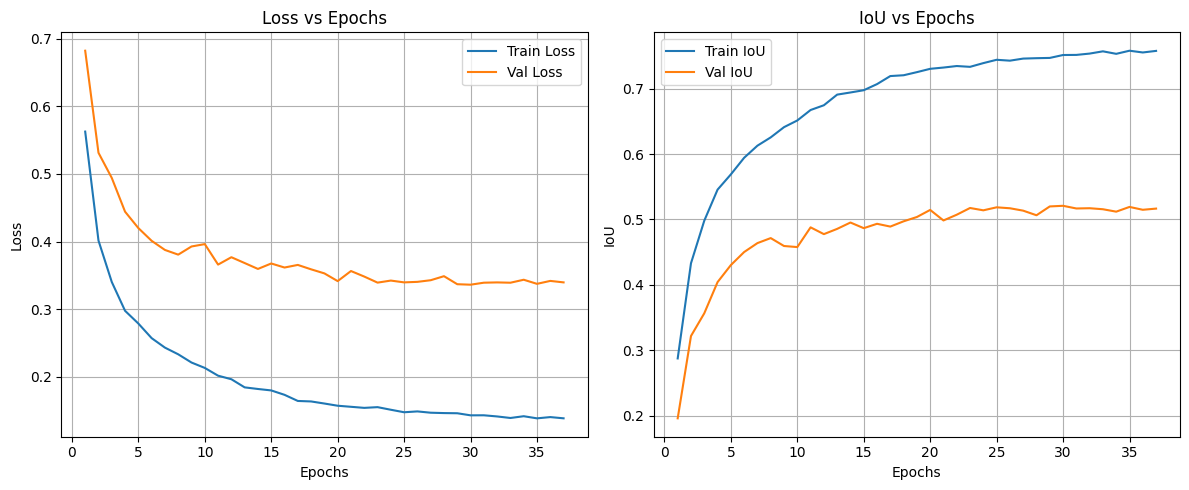

In [80]:
import matplotlib.pyplot as plt

# Access training history
train_loss = history.history['loss']
val_loss = history.history.get('val_loss')  # Use .get() in case you trained without val
train_iou = history.history.get('iou_metric')
val_iou = history.history.get('val_iou_metric')

epochs = range(1, len(train_loss) + 1)

# Plot Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Train Loss')
if val_loss:
    plt.plot(epochs, val_loss, label='Val Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Plot IoU
plt.subplot(1, 2, 2)
if train_iou:
    plt.plot(epochs, train_iou, label='Train IoU')
if val_iou:
    plt.plot(epochs, val_iou, label='Val IoU')
plt.title('IoU vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [81]:
from tensorflow.keras.models import load_model

model = load_model('/content/drive/MyDrive/best_deeplab_model.keras', compile=False)


In [82]:
val_generator = IRCADNPYDataset(
    patient_list=val_patients,
    base_path=base_dir,
    batch_size=1,
    input_size=(256, 256),
    shuffle=False,
    balance_data=False
)

test_generator = IRCADNPYDataset(
    patient_list=test_patients,
    base_path=base_dir,
    batch_size=1,
    input_size=(256, 256),
    shuffle=False,
    balance_data=False
)


<ipython-input-74-dc979a059531>:31: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=1, sigma=50, alpha_affine=10, p=0.2),


In [84]:
def predict_and_postprocess(generator):
    images, masks = [], []

    for i in range(len(generator)):
        img, mask = generator[i]
        pred = model.predict(img)[0]  # since batch_size=1
        pred_pp = postprocess_mask(pred)
        images.append(img[0])     # original image
        masks.append((mask[0], pred_pp))  # true vs predicted

    return images, masks


In [90]:
import numpy as np
import cv2
from scipy.ndimage import distance_transform_edt as distance
from scipy.ndimage import binary_closing, generate_binary_structure
from sklearn.metrics import jaccard_score, f1_score, accuracy_score
import matplotlib.pyplot as plt

# -------- Enhanced Postprocessing --------
def keep_largest_connected_component(mask):
    """
    Keep only the largest connected component in a 2D binary mask.
    """
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask, connectivity=8)
    if num_labels <= 1:
        return mask
    largest = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
    return (labels == largest).astype(np.uint8)

def smooth_boundaries(mask):
    blurred = cv2.GaussianBlur(mask.astype(np.float32), (5, 5), 0)
    return (blurred > 0.5).astype(np.uint8)

def postprocess_mask(pred_mask, threshold=0.5, use_3d=False):
    """
    Apply post-processing steps:
    - Thresholding
    - Morphology (2D or 3D)
    - Largest component
    - Smoothing
    """
    binary_mask = (pred_mask > threshold).astype(np.uint8)

    if use_3d:
        structure = generate_binary_structure(3, 2)
        binary_mask = binary_closing(binary_mask, structure=structure).astype(np.uint8)
    else:
        processed = np.zeros_like(binary_mask)
        for i in range(binary_mask.shape[0]):
            slice_mask = binary_mask[i]
            kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
            opened = cv2.morphologyEx(slice_mask, cv2.MORPH_OPEN, kernel)
            closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel)
            largest = keep_largest_connected_component(closed)
            smoothed = smooth_boundaries(largest)
            processed[i] = smoothed
        binary_mask = processed

    return binary_mask

# --------- Metrics ---------
def dice_coefficient(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection) / (np.sum(y_true_f) + np.sum(y_pred_f) + 1e-7)

def volume_overlap_error(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    return 1 - (intersection / (union + 1e-7))

def relative_volume_difference(y_true, y_pred):
    return (np.sum(y_pred) - np.sum(y_true)) / (np.sum(y_true) + 1e-7)

def assd(y_true, y_pred):
    def surface_distance(a, b):
        a_dist = distance(1 - a)
        b_dist = distance(1 - b)
        sds = []
        for i in np.argwhere(a):
            sds.append(b_dist[tuple(i)])
        for i in np.argwhere(b):
            sds.append(a_dist[tuple(i)])
        return np.array(sds)

    sds = []
    for i in range(y_true.shape[0]):
        s = surface_distance(y_true[i], y_pred[i])
        if s.size > 0:
            sds.append(np.mean(s))
    return np.mean(sds) if sds else 0.0

def rmsd(y_true, y_pred):
    all_dists = []
    for i in range(y_true.shape[0]):
        dists = distance(1 - y_true[i]) * y_pred[i] + distance(1 - y_pred[i]) * y_true[i]
        dists = dists[np.logical_or(y_true[i], y_pred[i])]
        if dists.size > 0:
            all_dists.append(np.sqrt(np.mean(dists**2)))
    return np.mean(all_dists) if all_dists else 0.0

# --------- Evaluation ---------
def evaluate_predictions(y_true_list, y_pred_list):
    y_true_flat = np.concatenate([yt.flatten() for yt in y_true_list])
    y_pred_flat = np.concatenate([yp.flatten() for yp in y_pred_list])

    metrics = {
        'Accuracy': accuracy_score(y_true_flat, y_pred_flat),
        'F1 Score': f1_score(y_true_flat, y_pred_flat),
        'IoU': jaccard_score(y_true_flat, y_pred_flat),
        'Dice Coefficient': np.mean([dice_coefficient(yt, yp) for yt, yp in zip(y_true_list, y_pred_list)]),
        'VOE': np.mean([volume_overlap_error(yt, yp) for yt, yp in zip(y_true_list, y_pred_list)]),
        'RVD': np.mean([relative_volume_difference(yt, yp) for yt, yp in zip(y_true_list, y_pred_list)]),
        'ASSD': np.mean([assd(yt, yp) for yt, yp in zip(y_true_list, y_pred_list)]),
        'RMSD': np.mean([rmsd(yt, yp) for yt, yp in zip(y_true_list, y_pred_list)]),
    }
    return metrics

# --------- Predict & Postprocess ---------
def predict_and_postprocess(generator, model, use_3d=False):
    images, true_masks, pred_masks = [], [], []

    for i in range(len(generator)):
        img_batch, mask_batch = generator[i]
        pred_batch = model.predict(img_batch)

        for j in range(img_batch.shape[0]):
            img = img_batch[j]
            true = mask_batch[j]
            pred = postprocess_mask(pred_batch[j], use_3d=use_3d)
            images.append(img)
            true_masks.append(true)
            pred_masks.append(pred)

    return images, true_masks, pred_masks

# --------- Display Metrics ---------
def display_metrics(val_metrics, test_metrics):
    print("\n" + "=" * 60)
    print(f"{'Metric':<20} {'Validation':<15} {'Test':<15}")
    print("=" * 60)
    for key in val_metrics:
        print(f"{key:<20} {val_metrics[key]:<15.4f} {test_metrics[key]:<15.4f}")
    print("=" * 60)

# --------- Main ---------
def main(use_3d_post=False):
    global model, val_generator, test_generator  # Ensure defined elsewhere

    print("Predicting validation data...")
    val_images, val_true, val_pred = predict_and_postprocess(val_generator, model, use_3d=use_3d_post)

    print("Predicting test data...")
    test_images, test_true, test_pred = predict_and_postprocess(test_generator, model, use_3d=use_3d_post)

    print("Evaluating validation metrics...")
    val_metrics = evaluate_predictions(val_true, val_pred)

    print("Evaluating test metrics...")
    test_metrics = evaluate_predictions(test_true, test_pred)

    display_metrics(val_metrics, test_metrics)

    return {
        'val_images': val_images,
        'val_true_masks': val_true,
        'val_pred_masks': val_pred,
        'test_images': test_images,
        'test_true_masks': test_true,
        'test_pred_masks': test_pred,
        'val_metrics': val_metrics,
        'test_metrics': test_metrics
    }

# Run it
if __name__ == "__main__":
    results = main(use_3d_post=False)  # Set to True to use 3D morphology


Predicting validation data...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━

In [46]:
!pip install pydicom nibabel matplotlib numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 37.9 MB/s eta 0:00:00


In [91]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np

def visualize_liver_predictions(images, true_masks, pred_masks, n_samples=3, figsize=(15, 10), title='Prediction Visualization'):
    """
    Visualize real liver CT images with ground truth and predicted segmentation masks.

    Parameters:
    - images: List or array of image arrays (2D or 3D per slice)
    - true_masks: List or array of ground truth masks
    - pred_masks: List or array of predicted masks (post-processed)
    - n_samples: Number of samples to visualize
    - figsize: Size of the figure
    - title: Title of the figure
    """
    n_samples = min(n_samples, len(images))

    colors = {
        'gt': [0, 1, 0, 0.5],    # Green
        'pred': [1, 0, 0, 0.5],  # Red
        'tp': [1, 1, 0, 0.7],    # Yellow
    }

    fig, axes = plt.subplots(3, n_samples, figsize=figsize, dpi=300)
    if n_samples == 1:
        axes = np.expand_dims(axes, axis=1)

    for i in range(n_samples):
        img = np.squeeze(images[i])
        gt = np.squeeze(true_masks[i])
        pred = np.squeeze(pred_masks[i])

        # Normalize image
        img = (img - img.min()) / (img.max() - img.min() + 1e-8)

        tp = (gt > 0.5) & (pred > 0.5)
        fp = (gt <= 0.5) & (pred > 0.5)
        fn = (gt > 0.5) & (pred <= 0.5)

        # --- Original CT ---
        axes[0, i].imshow(img, cmap='gray')
        axes[0, i].set_title(f"Image {i+1}")
        axes[0, i].axis('off')

        # --- Ground Truth ---
        axes[1, i].imshow(img, cmap='gray')
        gt_overlay = np.zeros((*gt.shape, 4))
        gt_overlay[gt > 0.5] = colors['gt']
        axes[1, i].imshow(gt_overlay)
        axes[1, i].set_title("Ground Truth")
        axes[1, i].axis('off')

        # --- Prediction Overlay ---
        axes[2, i].imshow(img, cmap='gray')
        overlay = np.zeros((*gt.shape, 4))
        overlay[tp] = colors['tp']
        overlay[fp] = colors['pred']
        overlay[fn] = colors['gt']
        axes[2, i].imshow(overlay)
        axes[2, i].set_title("Prediction Overlay")
        axes[2, i].axis('off')

    # Add legend
    legend_elements = [
        Patch(facecolor=colors['gt'], label='False Negative (Missed)', edgecolor='black'),
        Patch(facecolor=colors['pred'], label='False Positive', edgecolor='black'),
        Patch(facecolor=colors['tp'], label='True Positive', edgecolor='black'),
    ]
    fig.legend(handles=legend_elements, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.02), fontsize=10)
    plt.suptitle(title, fontsize=14, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()


Predicting validation data...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━

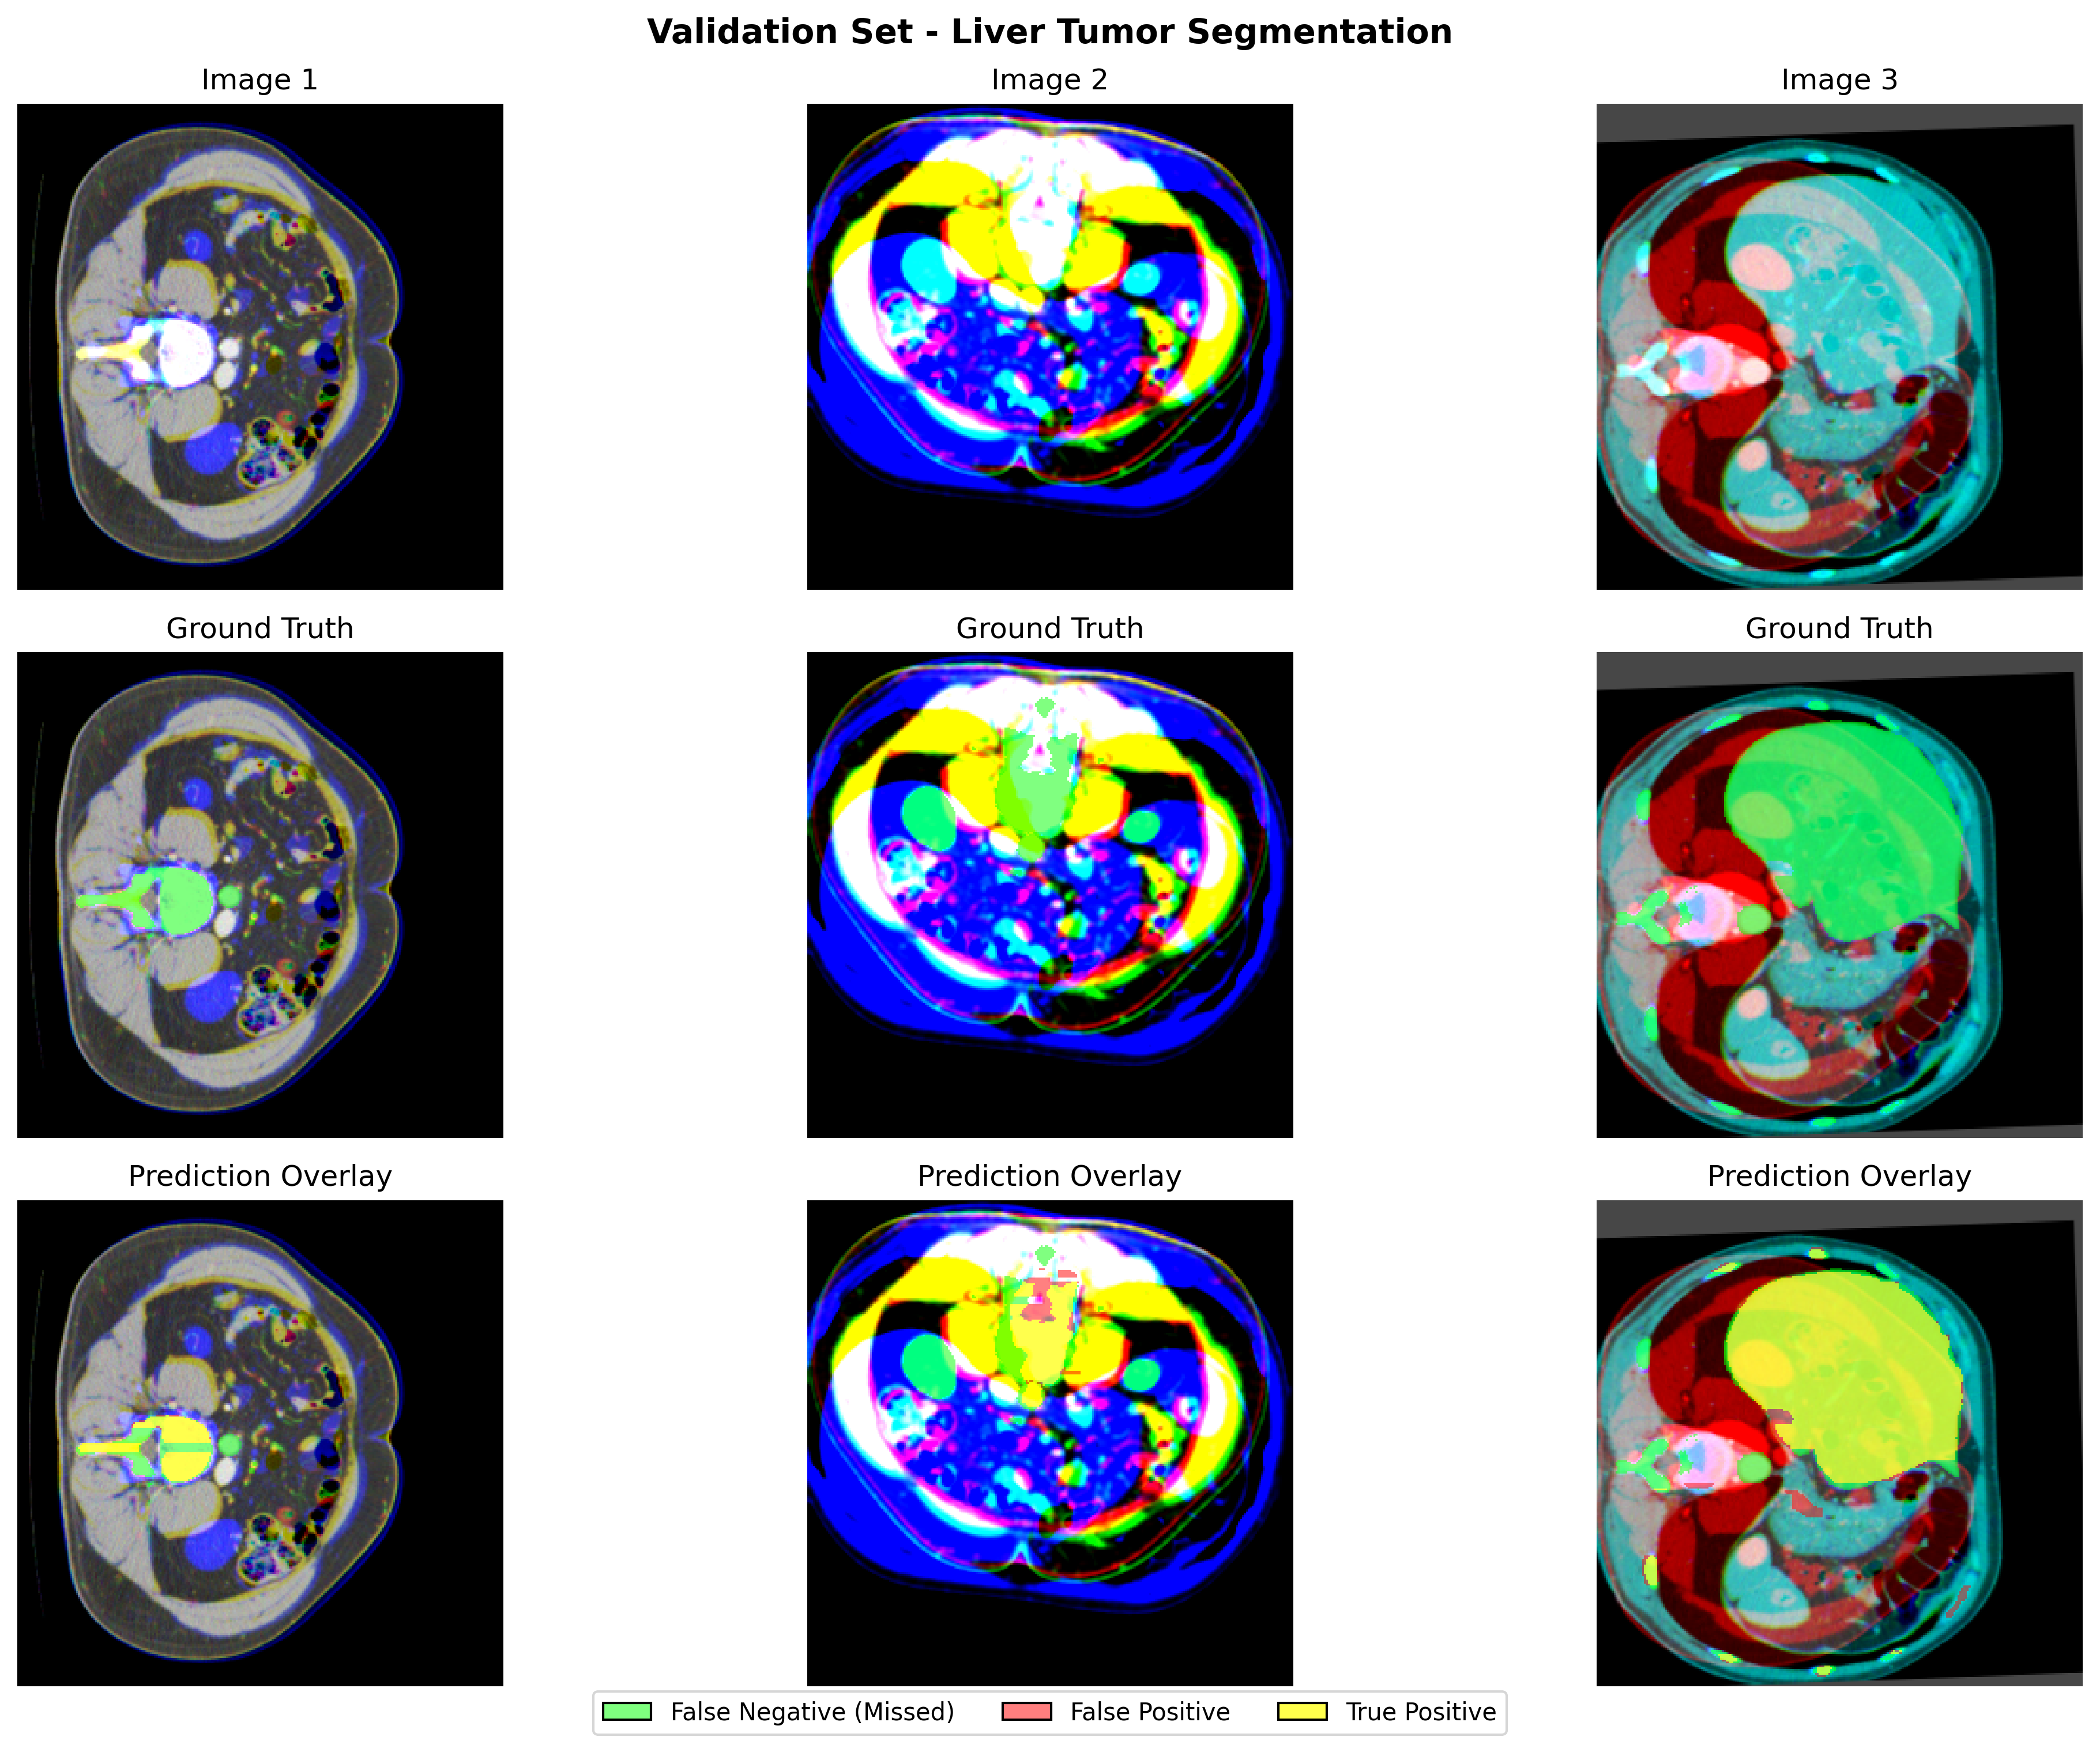

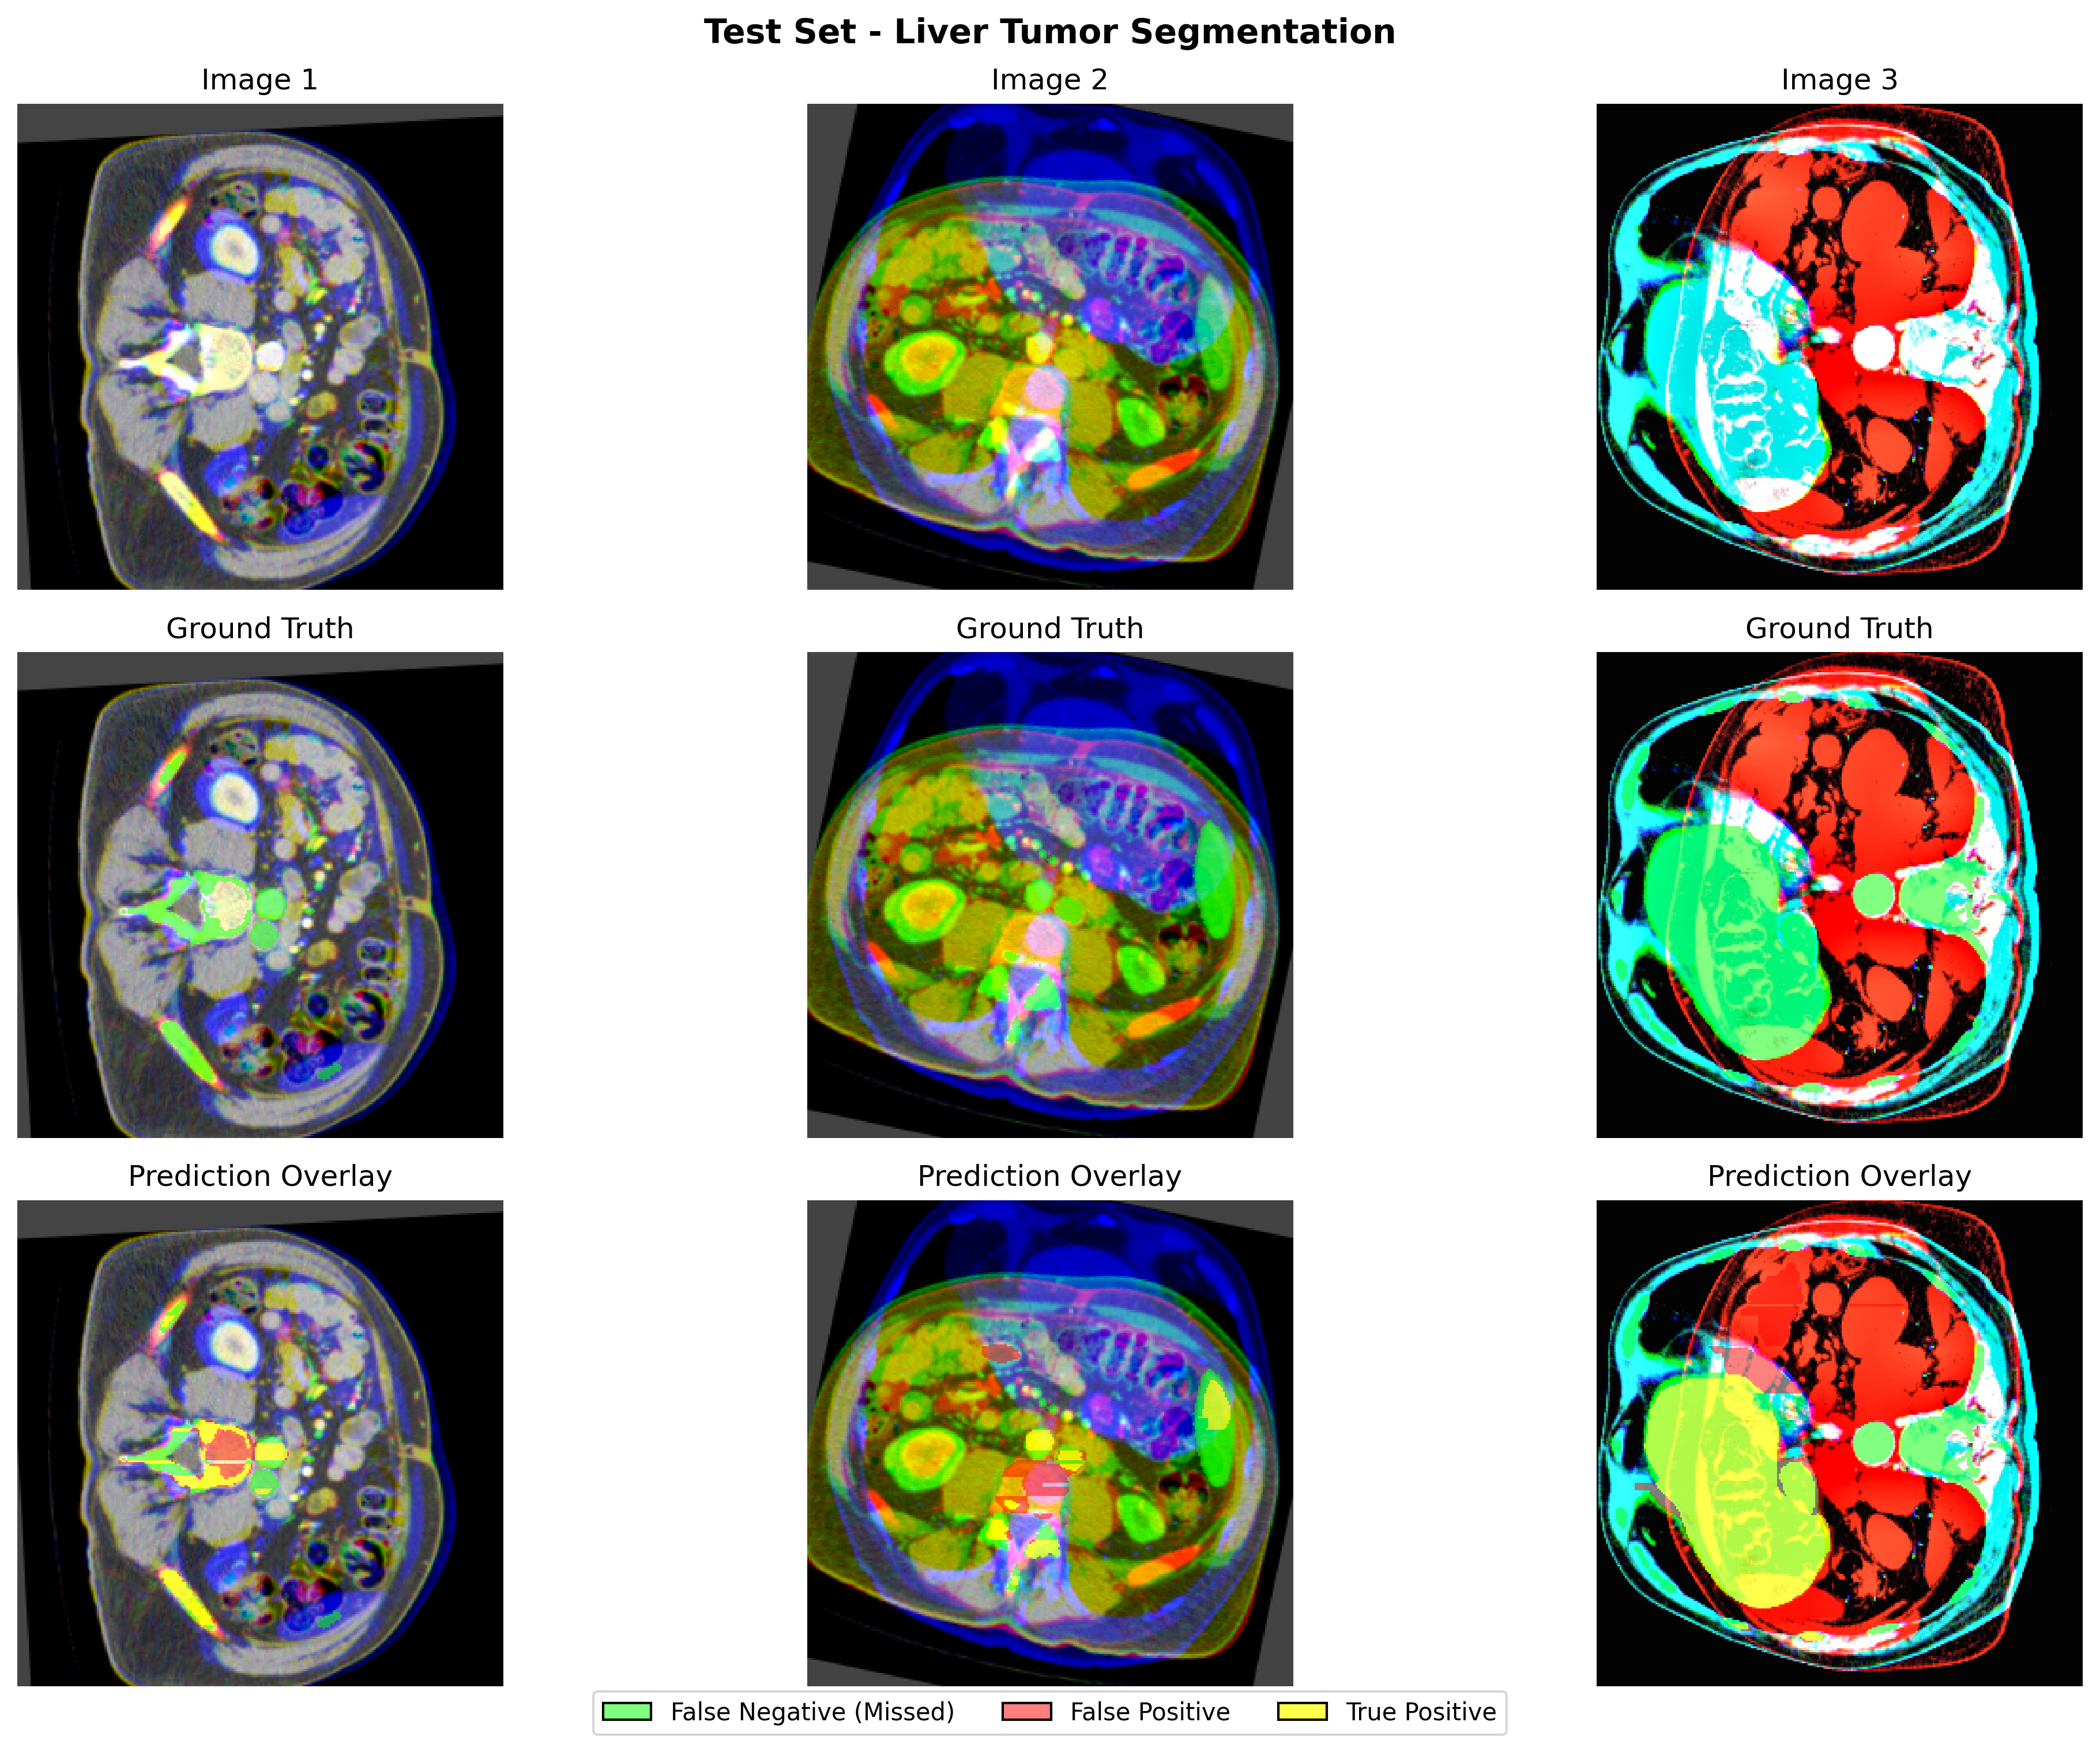

In [92]:
results = main()

# Visualize validation set
visualize_liver_predictions(
    results['val_images'],
    results['val_true_masks'],
    results['val_pred_masks'],
    n_samples=3,
    title="Validation Set - Liver Tumor Segmentation"
)

# Optional: Visualize test set
visualize_liver_predictions(
    results['test_images'],
    results['test_true_masks'],
    results['test_pred_masks'],
    n_samples=3,
    title="Test Set - Liver Tumor Segmentation"
)


In [93]:
def compute_confusion_elements(y_true, y_pred):
    """
    Compute TP, FP, FN, TN for binary segmentation masks.
    Both y_true and y_pred should be binary masks (0 and 1), same shape.
    """
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()

    TP = np.sum((y_pred_f == 1) & (y_true_f == 1))
    FP = np.sum((y_pred_f == 1) & (y_true_f == 0))
    FN = np.sum((y_pred_f == 0) & (y_true_f == 1))
    TN = np.sum((y_pred_f == 0) & (y_true_f == 0))

    return TP, FP, FN, TN


In [95]:
# Assuming you've already run your main evaluation:
val_true = results['val_true_masks']
val_pred = results['val_pred_masks']

# Now compute TP, FP, FN, TN over the whole validation set
all_tp, all_fp, all_fn, all_tn = 0, 0, 0, 0

for yt, yp in zip(val_true, val_pred):
    tp, fp, fn, tn = compute_confusion_elements(yt, yp)
    all_tp += tp
    all_fp += fp
    all_fn += fn
    all_tn += tn

print(f"Total TP: {all_tp}, FP: {all_fp}, FN: {all_fn}, TN: {all_tn}")


Total TP: 2187591, FP: 1024053, FN: 905738, TN: 23145594
